## Importing Libraries

In [46]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data preprocessing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#Data Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# Miscellaneous
from tqdm import tqdm
import os
import random

## Reading the Data

In [2]:
image_data_paths = "C:\\Users\\tmost\\Documents\\Data-course\\Brain" # base directory where the brain image data is located
train_dir = os.path.join(image_data_paths,"Training")
test_dir = os.path.join(image_data_paths,"Testing")

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    real_label = ""
    if label in ['pituitary_tumor', 'pituitary']: 
        real_label = 'pituitary'
    elif label in ['no_tumor', 'notumor']:
        real_label = 'notumor'
    elif label in ['meningioma', 'meningioma_tumor']:
        real_label = 'meningioma'
    elif label in ['glioma', 'glioma_tumor']:
        real_label = 'glioma'
    for image in os.listdir(os.path.join(train_dir,label)):
        train_paths.append(os.path.join(train_dir,label,image))
        train_labels.append(real_label)

train_paths, train_labels = shuffle(train_paths, train_labels)

print(f'training image number: {len(train_paths)}')

training image number: 2870


## Data Visualization Distribution for each class

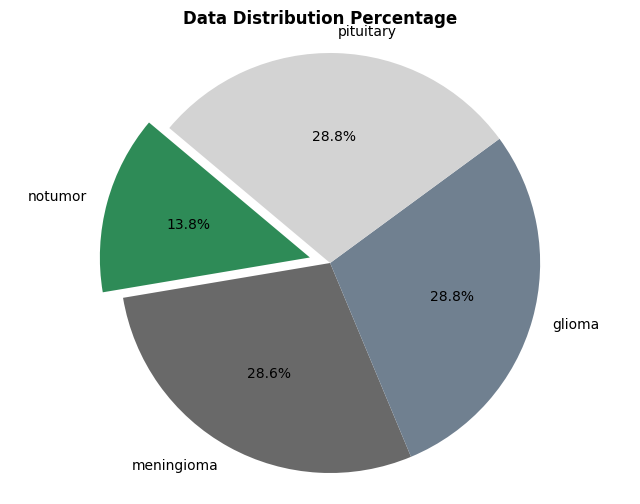

In [3]:
# Assuming you have label_percentages calculated as mentioned in your code
label_counts = {label: train_labels.count(label) for label in set(train_labels)}  # Count occurrences of each label
total_count = sum(label_counts.values())  # sum
label_percentages = {label: count / total_count * 100 for label, count in label_counts.items()}  # percentage

# Create a pie chart
plt.figure(figsize=(8, 6))
colors = ['seagreen', 'dimgray', 'slategrey', 'lightgray']
explode = (0.1, 0, 0, 0)  # Explode the 1st slice (optional, for emphasis)
plt.pie(label_percentages.values(), labels=label_percentages.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data Distribution Percentage', weight='bold')
plt.show()


In [4]:
image_data_paths = "C:\\Users\\tmost\\Documents\\Data-course\\Brain"
train_dir = os.path.join(image_data_paths,"Training")
test_dir = os.path.join(image_data_paths,"Testing")

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    real_label = ""
    if label in ['pituitary_tumor', 'pituitary']: 
        real_label = 'pituitary'
    elif label in ['no_tumor', 'notumor']:
        real_label = 'notumor'
    elif label in ['meningioma', 'meningioma_tumor']:
        real_label = 'meningioma'
    elif label in ['glioma', 'glioma_tumor']:
        real_label = 'glioma'
    for image in os.listdir(os.path.join(test_dir,label)):
        test_paths.append(os.path.join(test_dir,label,image))
        test_labels.append(real_label)

test_paths, test_labels = shuffle(test_paths, test_labels)

print(f'training image number: {len(test_paths)}')

training image number: 394


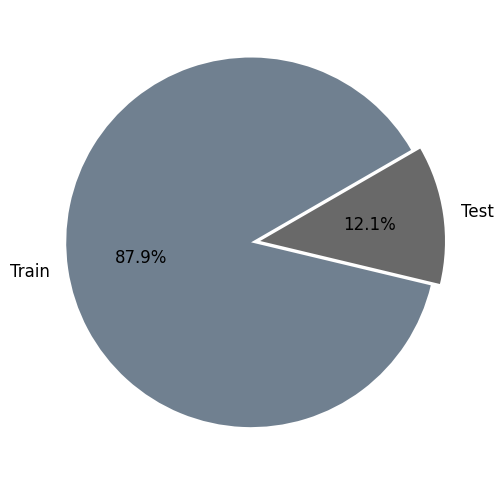

In [5]:
plt.figure(figsize=(12,6))
colors = ['slategrey','dimgray','seagreen','black']
plt.rcParams.update({'font.size': 12})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

## Data Agumentation

- Image augmentation is usually used to increase the image dataset and also to make the network more robust against translation invariance. 



- Image augmentation is defined as creating duplicates of the original image datasets by flipping, rotating, zooming, and adjusting brightness.

- Convert from NumPy to PIL

- Enhance Brightness and contrast

- After PIL transformation, Convert back to NumPy array and pixel are normalized 

def augment_image(image):
    image = Image.fromarray(np.uint8(image)) #convert this NumPy array to a PIL Image(python image library), unit8[0-255]
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2)) 
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0  # converted back to  NumPy array and Normalize
    return image

In [111]:
def augment_image(image):
    # Convert NumPy array to a PIL Image
    image = Image.fromarray(np.uint8(image))
    
    # Apply Keras-style augmentations
    image = image.rotate(random.uniform(-15, 15))
    image = image.transpose(method = Image.FLIP_LEFT_RIGHT) if random.choice([True, False]) else image
    image = image.transpose(method = Image.FLIP_TOP_BOTTOM) if random.choice([True, False]) else image
    
    # Apply additional custom augmentations
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.3, 1.5))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.3, 1.5))

    # Convert back to NumPy array and normalize
    image = np.array(image) / 255.0  
    
    return image

C:\Users\tmost\AppData\Local\Temp\ipykernel_28164\1778990939.py:8: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  image = image.transpose(method = Image.FLIP_TOP_BOTTOM) if random.choice([True, False]) else image
C:\Users\tmost\AppData\Local\Temp\ipykernel_28164\1778990939.py:7: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  image = image.transpose(method = Image.FLIP_LEFT_RIGHT) if random.choice([True, False]) else image


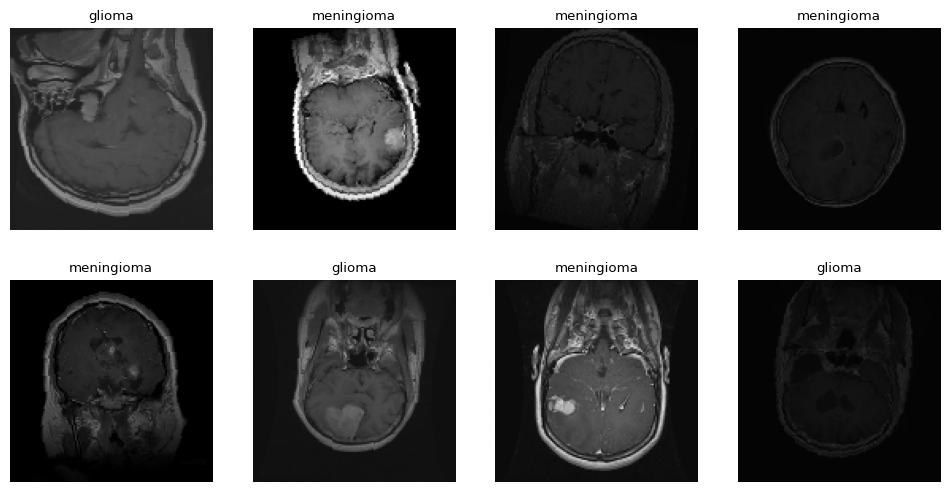

In [112]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))  #load and resize
        image = augment_image(image) # apply data augmentation to each image
        images.append(image) #append the augumented image to the image list
    return np.array(images)  #return an array

images = open_images(train_paths[11:20])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Data Generator

- Given a list of paths to images, and the labels,
- this function augments the images, normalizes them, encodes the label, and then returns the batch on which the model can train on.

In [113]:
unique_labels = ['glioma','meningioma','notumor','pituitary']#os.listdir(train_dir)


def encode_label(labels): # encode for feeding to ML
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x)) 
    return np.array(encoded)

def decode_label(labels):  #decode to be interpretation  
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1): #use data generator to efficiently load and process data in baches during training
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

- VGG is a CNN model, use for imgae classification task, conv layer --> max pooling layers --> deep structure

- Fully connected layer(top layers) -> exclude (the top layerd are often task specific, not directly tailored to a specific requirnments)


- Fearure Extraction: the low layer of pretrained model capture a general feature-> so useful for variety of task


- by excluding the top layers, you can leverage the lower layer for feature extraction and add your own classification layers for new task

- Use VGG16 for transfer learning, 

- Transfer learning, using knowledge from pre-trained model to improve performance

- trainable = False, layer --> Frozen (the weight of that layers will not update during the training)

- why? Reserving pre_Trained Knowledge,Reduce Training time, Avoiding overfitting

- so froyzen layers, it's a common practice in transfer learning

## Model

In [114]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet') 
# Set all layers to non-trainable
for layer in base_model.layers:  # loop through all layers in VGG16
    layer.trainable = False    
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True   #unfreeze the last 3 layers
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


# build a custom model of VGG16
model = Sequential()    
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))) # add input layer with the specified shape
model.add(base_model) #Adds the pre-trained VGG16 base model to the model.
model.add(Flatten())  #Flattens the output of the VGG16 base
model.add(Dropout(0.3)) # Applies dropout with a rate of 0.3 to reduce overfitting.
model.add(Dense(128, activation='relu')) # Adds a fully connected layer with 128 units and ReLU activation.
model.add(Dropout(0.2)) # Applies another dropout with a rate of 0.2.
model.add(Dense(len(unique_labels), activation='softmax')) #adds the final dense layer

In [115]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_10 (Dropout)        (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
N

In [116]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [117]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

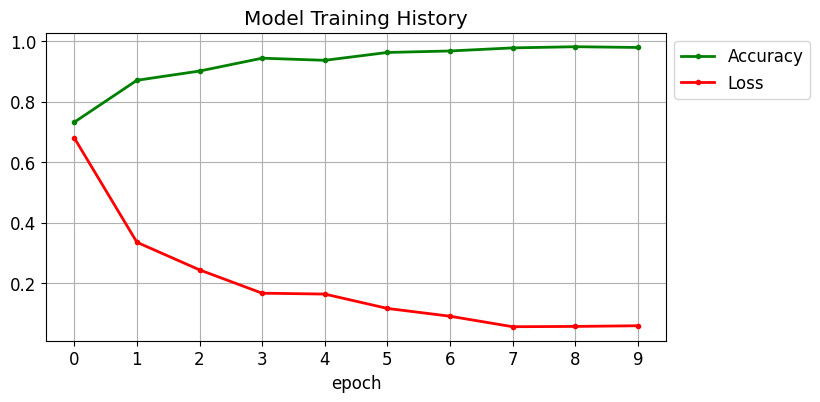

In [118]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
%%time
batch_size = 25
steps = int(len(train_paths)/batch_size)
epochs = 10
#history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),epochs=epochs, steps_per_epoch=steps)
# Create a data generator for training
train_generator = datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs)

# Train the model using the data generator
history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps)


C:\Users\tmost\AppData\Local\Temp\ipykernel_28164\1778990939.py:7: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  image = image.transpose(method = Image.FLIP_LEFT_RIGHT) if random.choice([True, False]) else image
C:\Users\tmost\AppData\Local\Temp\ipykernel_28164\1778990939.py:8: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  image = image.transpose(method = Image.FLIP_TOP_BOTTOM) if random.choice([True, False]) else image


Epoch 1/10
114/114 [==============================] - 391s 3s/step - loss: 0.9394 - sparse_categorical_accuracy: 0.6018
Epoch 2/10
  3/114 [..............................] - ETA: 6:24 - loss: 0.5838 - sparse_categorical_accuracy: 0.7857

## Evaluate Model with test samples

In [43]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  8%|██████▉                                                                            | 1/12 [00:01<00:15,  1.37s/it]

1/1 [==============================] - 1s 1s/step


 17%|█████████████▊                                                                     | 2/12 [00:02<00:14,  1.47s/it]

1/1 [==============================] - 1s 1s/step


 25%|████████████████████▊                                                              | 3/12 [00:04<00:13,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 33%|███████████████████████████▋                                                       | 4/12 [00:05<00:12,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 42%|██████████████████████████████████▌                                                | 5/12 [00:07<00:10,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:08<00:09,  1.51s/it]

1/1 [==============================] - 1s 1s/step


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:10<00:07,  1.50s/it]

1/1 [==============================] - 1s 1s/step


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:12<00:06,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:13<00:04,  1.56s/it]

1/1 [==============================] - 1s 1s/step


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:15<00:03,  1.57s/it]

1/1 [==============================] - 1s 1s/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:16<00:01,  1.59s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.60s/it]

1/1 [==============================] - 0s 383ms/step


13it [00:19,  1.47s/it]                                                                                                


In [47]:
# confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[ 18  58  24   0]
 [  0 114   1   0]
 [  0   1 104   0]
 [  1  11   7  55]]


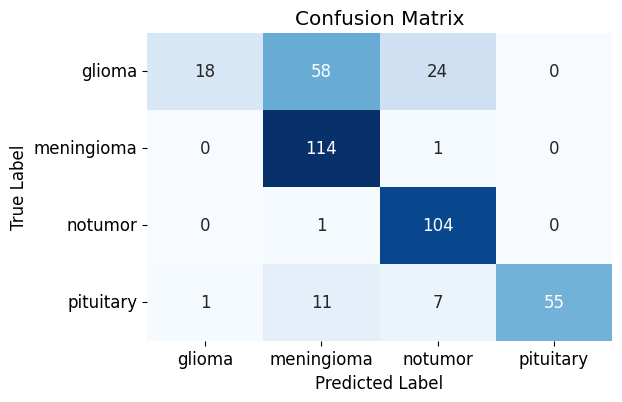

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Your confusion matrix data
conf_matrix_data = np.array([[18, 58, 24, 0],
                             [0, 114, 1, 0],
                             [0, 1, 104, 0],
                             [1, 11, 7, 55]])

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=unique_labels,
            yticklabels= unique_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [44]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.95      0.18      0.30       100
  meningioma       0.62      0.99      0.76       115
     notumor       0.76      0.99      0.86       105
   pituitary       1.00      0.74      0.85        74

    accuracy                           0.74       394
   macro avg       0.83      0.73      0.70       394
weighted avg       0.81      0.74      0.69       394



In [45]:
# Save the VGG16 model
save_path = 'C:\\Users\\tmost\\Documents\\Data-course\\Brain\\saved_models'
model.save(os.path.join(save_path, 'vgg16_model.h5'))

In [94]:
FP =[]
for i, y in enumerate(y_pred):
    if y != y_true[i]:
        FP.append(i)
        
FP_paths = []
FP_labels = []


for y in FP: 
    FP_paths.append(test_paths[y])
    FP_labels.append(y_true[y]+'-'+y_pred[y])
    

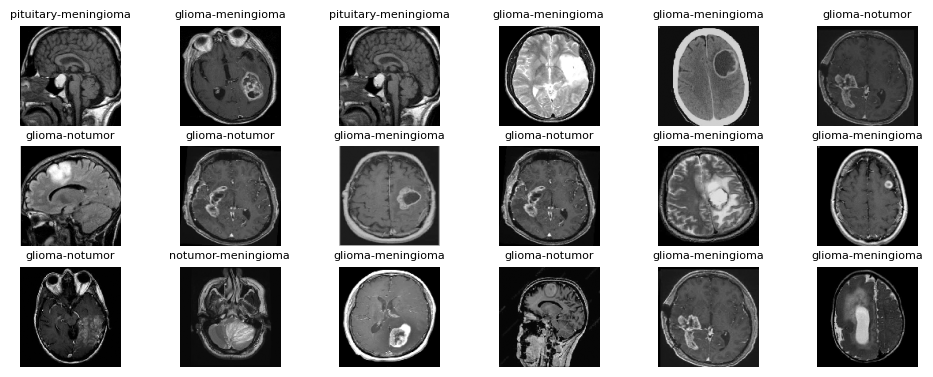

In [98]:
IMAGE_SIZE = 128


images = open_images(FP_paths[0:20])
labels = FP_labels[0:20]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 19):
    fig.add_subplot(4, 6, x)
    plt.axis('off')
    plt.title(labels[x], fontsize=8)
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 8})
plt.show()

In [109]:
import h5py
mat_file = h5py.File(r'C:\\Users\tmost\Documents\Data-course\Brain\brain_tumor_dataset\cvind.mat')
arrays = {}
for k, v in mat_file.items():
    arrays[k] = np.array(v)

In [110]:
arrays

{'cvind': array([[5., 5., 5., ..., 4., 2., 1.]])}